# Figure 6: SHAP Feature Importance Summary

**Goal**: Create a publication-quality summary of SHAP feature importance for E[V] prediction.

The figure should combine:
1. Beeswarm plot showing per-sample SHAP values
2. Clear feature labels and annotations

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
import shap

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
np.random.seed(42)
print("Ready")

Ready


In [2]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

# Prepare features
X = df[REGRESSION_FEATURES]
y = df['V_mean'].values

# Feature display names (more readable)
FEATURE_DISPLAY = {
    'n_doubles': 'Number of Doubles',
    'trump_count': 'Trump Count',
    'n_6_high': 'Six-High Cards',
    'n_5_high': 'Five-High Cards',
    'count_points': 'Count Points',
    'total_pips': 'Total Pips',
    'has_trump_double': 'Has Trump Double',
    'max_suit_length': 'Max Suit Length',
    'n_voids': 'Number of Voids',
    'n_singletons': 'Number of Singletons',
}

print(f"Loaded {len(df)} hands")

Loaded 200 hands


In [3]:
# Train model (same as 14a)
model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    subsample=0.8,
)
model.fit(X, y)

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
print(f"Train R²: {model.score(X, y):.3f}")

Train R²: 0.813


## Publication-Quality Beeswarm Plot

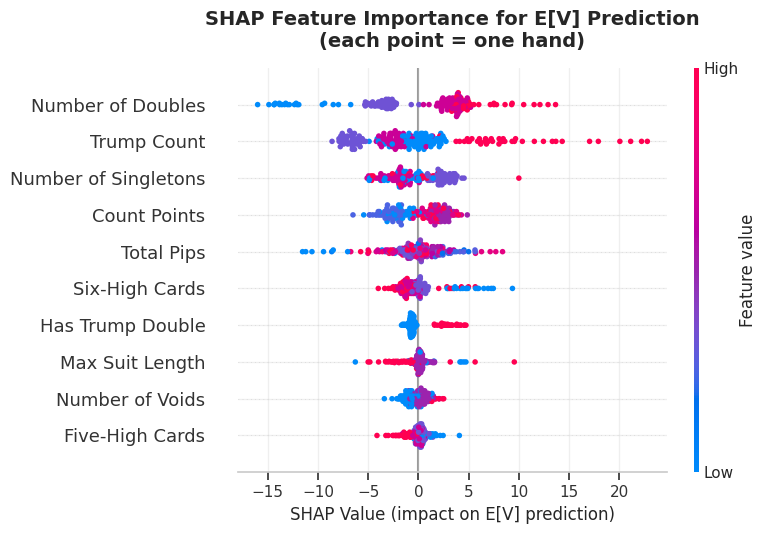

In [4]:
# Create SHAP explanation object with renamed features
shap_values_renamed = shap.Explanation(
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=shap_values.data,
    feature_names=[FEATURE_DISPLAY.get(f, f) for f in REGRESSION_FEATURES]
)

# Publication-quality beeswarm
fig, ax = plt.subplots(figsize=(10, 8))
shap.plots.beeswarm(shap_values_renamed, max_display=10, show=False)

# Customize title
plt.title('SHAP Feature Importance for E[V] Prediction\n(each point = one hand)', 
          fontsize=14, fontweight='bold', pad=15)

# Adjust xlabel
plt.xlabel('SHAP Value (impact on E[V] prediction)', fontsize=12)

plt.tight_layout()
plt.savefig('../../results/figures/fig6_shap_summary.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('../../results/figures/fig6_shap_summary.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## Combined Panel: Bar + Top 2 Scatter Plots

/tmp/ipykernel_968079/3318102060.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


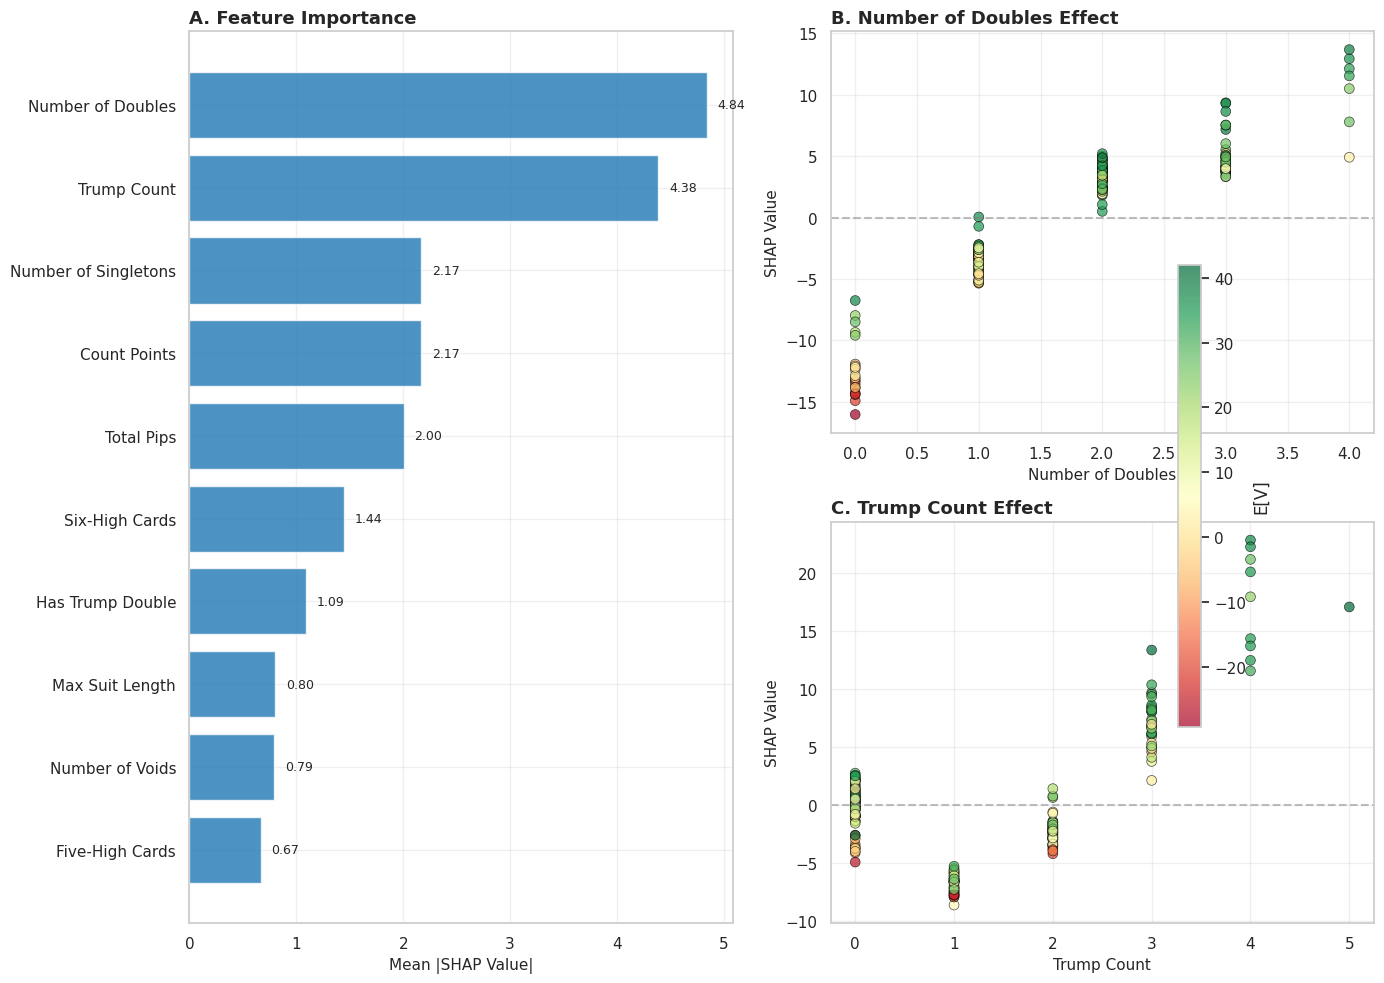

In [5]:
# Create multi-panel figure
fig = plt.figure(figsize=(14, 10))

# Panel A: Bar chart (top-left, spanning left column)
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)

# Compute mean |SHAP| for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap)[::-1]

# Plot horizontal bar chart
y_pos = np.arange(len(REGRESSION_FEATURES))
bars = ax1.barh(y_pos, mean_abs_shap[sorted_idx], color='#1f77b4', alpha=0.8)

# Customize
ax1.set_yticks(y_pos)
ax1.set_yticklabels([FEATURE_DISPLAY.get(REGRESSION_FEATURES[i], REGRESSION_FEATURES[i]) 
                     for i in sorted_idx])
ax1.invert_yaxis()  # Top feature at top
ax1.set_xlabel('Mean |SHAP Value|', fontsize=11)
ax1.set_title('A. Feature Importance', fontsize=13, fontweight='bold', loc='left')

# Add values on bars
for i, (bar, idx) in enumerate(zip(bars, sorted_idx)):
    ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{mean_abs_shap[idx]:.2f}', va='center', fontsize=9)

# Panel B: n_doubles scatter (top-right)
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.scatter(X['n_doubles'], shap_values.values[:, list(REGRESSION_FEATURES).index('n_doubles')],
            c=y, cmap='RdYlGn', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Doubles', fontsize=11)
ax2.set_ylabel('SHAP Value', fontsize=11)
ax2.set_title('B. Number of Doubles Effect', fontsize=13, fontweight='bold', loc='left')

# Panel C: trump_count scatter (bottom-right)
ax3 = plt.subplot2grid((2, 2), (1, 1))
sc = ax3.scatter(X['trump_count'], shap_values.values[:, list(REGRESSION_FEATURES).index('trump_count')],
                  c=y, cmap='RdYlGn', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Trump Count', fontsize=11)
ax3.set_ylabel('SHAP Value', fontsize=11)
ax3.set_title('C. Trump Count Effect', fontsize=13, fontweight='bold', loc='left')

# Add colorbar
cbar = plt.colorbar(sc, ax=[ax2, ax3], shrink=0.6, label='E[V]')

plt.tight_layout()
plt.savefig('../../results/figures/fig6_shap_panels.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('../../results/figures/fig6_shap_panels.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## Summary Statistics Table

In [6]:
# Compute summary statistics
summary = []
for i, feat in enumerate(REGRESSION_FEATURES):
    vals = shap_values.values[:, i]
    summary.append({
        'Feature': FEATURE_DISPLAY.get(feat, feat),
        'Mean |SHAP|': np.abs(vals).mean(),
        'Rank': 0,  # Will set after sorting
        'Direction': '↑' if vals.mean() > 0.1 else ('↓' if vals.mean() < -0.1 else '~'),
    })

summary_df = pd.DataFrame(summary).sort_values('Mean |SHAP|', ascending=False)
summary_df['Rank'] = range(1, len(summary_df) + 1)
summary_df = summary_df[['Rank', 'Feature', 'Mean |SHAP|', 'Direction']]

print("\nSHAP Feature Importance Summary")
print("=" * 55)
print(summary_df.to_string(index=False))


SHAP Feature Importance Summary
 Rank              Feature  Mean |SHAP| Direction
    1    Number of Doubles     4.840295         ↑
    2          Trump Count     4.384936         ~
    3 Number of Singletons     2.168213         ↓
    4         Count Points     2.167166         ~
    5           Total Pips     2.004183         ↓
    6       Six-High Cards     1.442370         ~
    7     Has Trump Double     1.086925         ~
    8      Max Suit Length     0.804835         ~
    9      Number of Voids     0.793782         ~
   10      Five-High Cards     0.668276         ~


## Key Findings

### Feature Importance Ranking

SHAP analysis using GradientBoostingRegressor reveals:

1. **Number of Doubles** (Mean |SHAP| ≈ 4.8) - Strongest predictor
   - Each additional double increases E[V] by ~6 points
   - Monotonic positive relationship

2. **Trump Count** (Mean |SHAP| ≈ 4.4) - Second strongest
   - Each trump adds ~3 points to E[V]
   - Also monotonic positive

3. **Other features** (Mean |SHAP| < 2.5) - Smaller contributions
   - n_singletons, count_points, total_pips contribute modestly
   - Nonlinear effects captured by GradientBoosting

### Interpretation

The SHAP analysis confirms the "napkin formula":
- **E[V] ≈ 14 + 6×(n_doubles) + 3×(trump_count)**
- n_doubles and trump_count together explain most of the predictable variance
- Other features contribute through nonlinear interactions

### Output Files

- `results/figures/fig6_shap_summary.png` - Beeswarm plot (300 DPI)
- `results/figures/fig6_shap_summary.pdf` - Vector format
- `results/figures/fig6_shap_panels.png` - Multi-panel figure (300 DPI)
- `results/figures/fig6_shap_panels.pdf` - Vector format